In [119]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops

%matplotlib inline
np.random.seed(1)

In [120]:
def load_dataset():

    train_dataset = h5py.File('Downloads/train_signs.h5', "r")

    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features

    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels



    test_dataset = h5py.File('Downloads/test_signs.h5', "r")

    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features

    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels



    classes = np.array(test_dataset["list_classes"][:]) # the list of classes

    

    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))

    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

    

    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [121]:
X_train_orig,Y_train_orig,X_test_orig,Y_test_orig,classes = load_dataset()
print(X_train_orig.shape)
print(Y_train_orig.shape)
print(X_test_orig.shape)
print(Y_test_orig.shape)
print(classes)

(1080, 64, 64, 3)
(1, 1080)
(120, 64, 64, 3)
(1, 120)
[0 1 2 3 4 5]


y = 5


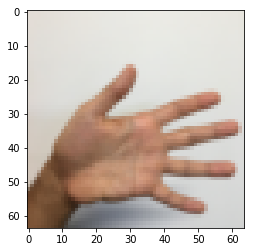

In [122]:
index = 0
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

In [123]:
def convert_to_one_hot(A,C):
    A = np.eye(C)[A.reshape(-1)].T
    return A

In [124]:
# Flatten the training and test images
X_train_flatten = X_train_orig.reshape(X_train_orig.shape[0], -1).T
X_test_flatten = X_test_orig.reshape(X_test_orig.shape[0], -1).T
# Normalize image vectors
X_train = X_train_flatten/255.
X_test = X_test_flatten/255.
# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 6)
Y_test = convert_to_one_hot(Y_test_orig, 6)

print ("number of training examples = " + str(X_train.shape[1]))
print ("number of test examples = " + str(X_test.shape[1]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (12288, 1080)
Y_train shape: (6, 1080)
X_test shape: (12288, 120)
Y_test shape: (6, 120)


In [125]:
def create_placeholders(nx,ny):
    X = tf.placeholder(tf.float32,shape = (nx,None),name = "X")
    Y = tf.placeholder(tf.float32,shape = (ny,None),name = "Y")
    return X,Y

In [126]:
X, Y = create_placeholders(12288, 6)
print ("X = " + str(X))
print ("Y = " + str(Y))

X = Tensor("X_1:0", shape=(12288, ?), dtype=float32)
Y = Tensor("Y_1:0", shape=(6, ?), dtype=float32)


In [130]:
def initialize_parameters(layer_dims):
    num_layer = len(layer_dims)
    
    parameters = {}
    tf.set_random_seed(1)
    for i in range(num_layer-1):
        parameters["W"+str(i+1)] = tf.get_variable("W"+str(i+1),[layer_dims[i+1],layer_dims[i]],initializer = tf.contrib.layers.xavier_initializer(seed=1))
        parameters["b"+str(i+1)] = tf.get_variable("b"+str(i+1),[layer_dims[i+1],1],initializer = tf.zeros_initializer())
    
    return parameters

In [131]:
tf.reset_default_graph()
layer_dims = [12288,25,12,6]
with tf.Session() as sess:
    parameters = initialize_parameters(layer_dims)
    print("W1 = " + str(parameters["W1"]))
    print("b1 = " + str(parameters["b1"]))
    print("W2 = " + str(parameters["W2"]))
    print("b2 = " + str(parameters["b2"]))
#print(parameters)

W1 = <tf.Variable 'W1:0' shape=(25, 12288) dtype=float32_ref>
b1 = <tf.Variable 'b1:0' shape=(25, 1) dtype=float32_ref>
W2 = <tf.Variable 'W2:0' shape=(12, 25) dtype=float32_ref>
b2 = <tf.Variable 'b2:0' shape=(12, 1) dtype=float32_ref>


In [132]:
def forward_propagation(X,parameters):
    num_layer = len(parameters)//2
    A_prev = X
    for i in range(num_layer-1):
        Wl = parameters["W"+str(i+1)]
        bl = parameters["b"+str(i+1)]
        Z = tf.add(tf.matmul(Wl,A_prev),bl)
        A = tf.nn.relu(Z)
        A_prev = A
    
    Z = tf.add(tf.matmul(parameters["W"+str(num_layer)],A_prev),parameters["b"+str(num_layer)])
    return Z
    

In [133]:

tf.reset_default_graph()

with tf.Session() as sess:
    X, Y = create_placeholders(12288, 6)
    parameters = initialize_parameters(layer_dims)
    Z3 = forward_propagation(X, parameters)
    print("Z3 = " + str(Z3))

Z3 = Tensor("Add_2:0", shape=(6, ?), dtype=float32)


In [134]:
def compute_cost(Z3,Y):
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Z3, labels=Y))
    return cost

In [135]:
tf.reset_default_graph()

with tf.Session() as sess:
    X, Y = create_placeholders(12288, 6)
    parameters = initialize_parameters(layer_dims)
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y)
    print("cost = " + str(cost))

cost = Tensor("Mean:0", shape=(), dtype=float32)


In [136]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):

    """

    Creates a list of random minibatches from (X, Y)

    Arguments:

    X -- input data, of shape (input size, number of examples)

    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)

    mini_batch_size - size of the mini-batches, integer

    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.

    

    Returns:

    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)

    """

    m = X.shape[1]                  # number of training examples

    mini_batches = []

    np.random.seed(seed)

    
    # Step 1: Shuffle (X, Y)

    permutation = list(np.random.permutation(m))

    shuffled_X = X[:, permutation]

    shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))



    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.

    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning

    for k in range(0, num_complete_minibatches):

        mini_batch_X = shuffled_X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]

        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]

        mini_batch = (mini_batch_X, mini_batch_Y)

        mini_batches.append(mini_batch)

    

    # Handling the end case (last mini-batch < mini_batch_size)

    if m % mini_batch_size != 0:

        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]

        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]

        mini_batch = (mini_batch_X, mini_batch_Y)

        mini_batches.append(mini_batch)

    

    return mini_batches

In [140]:
def model_reg(X_train, Y_train, X_test, Y_test, learning_rate,layer_dims,num_epochs, minibatch_size, print_cost):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
    X_train -- training set, of shape (input size = 12288, number of training examples = 1080)
    Y_train -- test set, of shape (output size = 6, number of training examples = 1080)
    X_test -- training set, of shape (input size = 12288, number of training examples = 120)
    Y_test -- test set, of shape (output size = 6, number of test examples = 120)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep consistent results
    seed = 3                                          # to keep consistent results
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of shape (n_x, n_y)
    X, Y = create_placeholders(n_x, n_y)

    # Initialize parameters
    parameters = initialize_parameters(layer_dims)
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z3 = forward_propagation(X, parameters)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(tf.transpose(Z3), tf.transpose(Y))
    weights=[]
    for i in range(len(parameters)//2):
        weights.append(parameters["W"+str(i+1)])
    regularization_penalty=tf.contrib.layers.apply_regularization(
    tf.contrib.layers.l2_regularizer(scale=0.1,scope=None),
    weights_list=weights)
    
    reg_cost=cost+regularization_penalty
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(reg_cost)
    #optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(cost)
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                _ , minibatch_cost = sess.run([optimizer, reg_cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                
                epoch_cost += minibatch_cost / num_minibatches

            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters

In [141]:
def model(X_train, Y_train, X_test, Y_test, learning_rate,layer_dims,num_epochs, minibatch_size, print_cost):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
    X_train -- training set, of shape (input size = 12288, number of training examples = 1080)
    Y_train -- test set, of shape (output size = 6, number of training examples = 1080)
    X_test -- training set, of shape (input size = 12288, number of training examples = 120)
    Y_test -- test set, of shape (output size = 6, number of test examples = 120)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep consistent results
    seed = 3                                          # to keep consistent results
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of shape (n_x, n_y)
    X, Y = create_placeholders(n_x, n_y)

    # Initialize parameters
    parameters = initialize_parameters(layer_dims)
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z3 = forward_propagation(X, parameters)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(tf.transpose(Z3), tf.transpose(Y))
   
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    #optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(cost)
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                
                epoch_cost += minibatch_cost / num_minibatches

            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters

Cost after epoch 0: 1.855702
Cost after epoch 100: 1.016458
Cost after epoch 200: 0.733102
Cost after epoch 300: 0.572939
Cost after epoch 400: 0.468774
Cost after epoch 500: 0.381021
Cost after epoch 600: 0.313827
Cost after epoch 700: 0.254280
Cost after epoch 800: 0.203799
Cost after epoch 900: 0.166512
Cost after epoch 1000: 0.140937
Cost after epoch 1100: 0.107750
Cost after epoch 1200: 0.086299
Cost after epoch 1300: 0.060949
Cost after epoch 1400: 0.050934


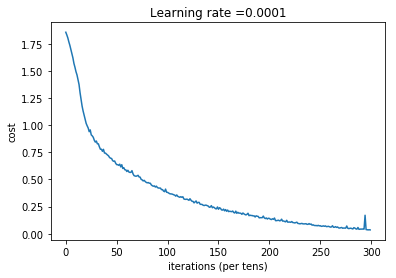

Parameters have been trained!
Train Accuracy: 0.9990741
Test Accuracy: 0.725


In [138]:
learning_rate = 0.0001
num_epochs = 1500
minibatch_size = 32
print_cost = True
parameters = model(X_train, Y_train, X_test, Y_test,learning_rate,layer_dims,num_epochs,minibatch_size,print_cost)

Cost after epoch 0: 5.258243
Cost after epoch 100: 1.589872
Cost after epoch 200: 1.457183
Cost after epoch 300: 1.406864
Cost after epoch 400: 1.366702
Cost after epoch 500: 1.347315
Cost after epoch 600: 1.354865
Cost after epoch 700: 1.326144
Cost after epoch 800: 1.315168
Cost after epoch 900: 1.305169
Cost after epoch 1000: 1.301716
Cost after epoch 1100: 1.322166
Cost after epoch 1200: 1.319363
Cost after epoch 1300: 1.296179
Cost after epoch 1400: 1.300364


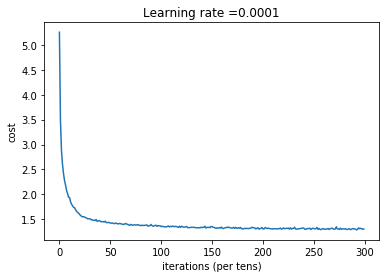

Parameters have been trained!
Train Accuracy: 0.8666667
Test Accuracy: 0.78333336


In [142]:
learning_rate = 0.0001
num_epochs = 1500
minibatch_size = 32
print_cost = True
parameters = model_reg(X_train, Y_train, X_test, Y_test,learning_rate,layer_dims,num_epochs,minibatch_size,print_cost)

In [143]:
print(parameters)

{'W1': array([[ 9.9408619e-34, -9.3028935e-34, -3.1378536e-34, ...,
        -6.6386999e-34,  6.6666123e-34,  4.0960175e-35],
       [ 2.7991717e-03,  4.3259687e-03,  5.3161392e-03, ...,
         3.7226394e-02,  4.5807235e-02,  4.6501063e-02],
       [-5.4445395e-34,  7.7966095e-34,  3.0951540e-34, ...,
         4.5335272e-34,  2.1710795e-34,  4.3348512e-34],
       ...,
       [ 9.5417621e-03,  1.0763531e-02,  1.8397789e-02, ...,
         3.0248521e-02,  1.6681550e-02,  2.7146896e-03],
       [ 6.8960192e-34,  1.0693938e-33,  3.1596303e-34, ...,
         6.7543125e-34,  6.1562494e-34,  5.0763209e-34],
       [-4.2002842e-34, -3.9065071e-34,  6.0675198e-34, ...,
         1.3867798e-34,  7.3077834e-34,  4.5721576e-35]], dtype=float32), 'b1': array([[-4.0018940e-03],
       [ 6.6139917e-03],
       [-1.1152878e-03],
       [-1.9176495e-03],
       [-9.8201330e-04],
       [-2.0515269e-03],
       [-2.2162315e-03],
       [ 1.2268395e-01],
       [-2.1658440e-03],
       [-2.6926419e-03],


In [144]:
def predict(X,parameters):
    params={}
    for i in range(len(parameters)//2):
        params["W"+str(i+1)]=tf.convert_to_tensor(parameters["W"+str(i+1)])
        params["b"+str(i+1)]=tf.convert_to_tensor(parameters["b"+str(i+1)])
        
    x = tf.placeholder("float", [X.shape[0], 1])
    z3 = forward_propagation(x, params)

    p = tf.argmax(z3)
    with tf.Session() as sess:

        prediction = sess.run(p, feed_dict = {x: X})

    return prediction    

c:\python36\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Your algorithm predicts: y = 1


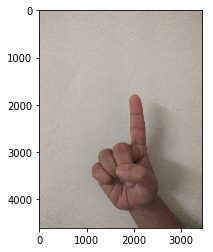

In [164]:
import scipy
from PIL import Image
import skimage.transform
from scipy import ndimage

my_image = "one.jpg"

# We preprocess your image to fit your algorithm.
fname = "Downloads/" + my_image
image = np.array(plt.imread(fname))
my_image = skimage.transform.resize(image, (64,64)).reshape((1, 64*64*3)).T
my_image_prediction = predict(my_image, parameters)

plt.imshow(image)
print("Your algorithm predicts: y = " + str(np.squeeze(my_image_prediction)))